In [6]:
import pandas as pd
from transformers import pipeline
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

2023-04-04 20:19:33.058794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 20:19:34.401347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 20:19:34.401368: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-04 20:19:38.021985: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Functions 

In [1]:
def get_vectors(lst_keywords, wv):
    
    # Creating the vectorizer 
    vectorizer = CountVectorizer(stop_words='english')

    # Fit the model with our data (each keyword becomes a feature, some are split)
    X = vectorizer.fit_transform(lst_keywords)

    # Make an array and fills it in
    CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Words in the vocabulary (some keywords are split)
    WordsVocab=CountVectorizedData.columns

    # Creating dataframe holding sentences
    #X_corpus_train = X
    #CountVecData=CountVectorizedData.iloc[:, :-1]
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data_temp=pd.DataFrame()
    
    Sentence_1=[[wv[word] if word in wv.key_to_index.keys() else np.zeros(300) for word in WordsVocab[CountVectorizedData.iloc[i , :]>=1]] for i in range(CountVectorizedData.shape[0])]
    W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_1))
    Sentence_2=[[wv[word.capitalize()] if word.capitalize() in wv.key_to_index.keys() and word not in wv.key_to_index.keys()  else np.zeros(300) for word in WordsVocab[CountVectorizedData.iloc[i , :]>=1]] for i in range(CountVectorizedData.shape[0])]
    W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_2))
    test_sum_df = W2Vec_Data_temp.groupby(W2Vec_Data_temp.index).sum()
    #W2Vec_Data = test_sum_df.sum(axis=1)
    test_sum_df[test_sum_df.applymap(lambda x: np.allclose(x, 0))] = np.nan
    
    W2Vec_Data_mean = test_sum_df.apply(lambda x: np.mean(x[x.notnull()]), axis=1)
    
    W2Vec_Data_df = pd.DataFrame(W2Vec_Data_mean)
    W2Vec_Data = W2Vec_Data_df[0].apply(pd.Series)
    #W2Vec_Data= W2Vec_Data_df_final
    #W2Vec_Data = pd.DataFrame([sum([wv[word] for word in WordsVocab[CountVectorizedData.iloc[i , :] >= 1] \
    #                                if word in wv.index_to_key]) for i in range(CountVectorizedData.shape[0])])
    
    return W2Vec_Data

In [305]:
def get_vectors_old(lst_keywords, wv):
    
    # Creating the vectorizer 
    vectorizer = CountVectorizer(stop_words='english')

    # Fit the model with our data (each keyword becomes a feature, some are split)
    X = vectorizer.fit_transform(lst_keywords)

    # Make an array and fills it in
    CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    # Words in the vocabulary (some keywords are split)
    WordsVocab=CountVectorizedData.columns

    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()

    # Looping through each row for the data
    for i in range(CountVectorizedData.shape[0]):

        # initiating a sentence with all zeros
        sentence = np.zeros(300)

        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVectorizedData.iloc[i , :] >= 1]:
            if word in wv.index_to_key:
                sentence = sentence + wv[word] 
        # Appending the sentence to the dataframe
        W2Vec_Data = W2Vec_Data.append(pd.DataFrame([sentence]))

    return W2Vec_Data

## Load data and models

In [3]:
# Specify wanted time range
start_date = '2019-02-01'
end_date = '2020-02-01'

# Where data files will be stored
path_to_data_files = '../../data/interim/'

# Load DW data
clean_data_file = path_to_data_files + '/clean_keywords_' + start_date + '_' + end_date + '.json'
df_dw = pd.read_json(clean_data_file, orient ='split', compression = 'infer')

# Load Google data
google_file = path_to_data_files + start_date + '_' + end_date + '_World_daily_trending_searches.json'
df_google = pd.read_json(google_file, orient ='split', compression = 'infer') 

In [7]:
# Runs for 1min20
# Load pre-trained zero shot learning model
pipe = pipeline(model="facebook/bart-large-mnli") 

# Loads word2vec google model
wv = api.load('word2vec-google-news-300')

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Match datasets in time

In [5]:
# Extract date range in data
start_date_dw = pd.to_datetime(df_dw['Date']).min()
end_date_dw = pd.to_datetime(df_dw['Date']).max()

# Remove rows witn no category
df_dw.dropna(subset=['cleanFocusCategory'], inplace = True)
df_dw.reset_index(drop = True, inplace = True)

# Keeps only google data within DW data date range
df_google.sort_values(by ='date', inplace = True) 
mask = (pd.to_datetime(df_google['date']) > start_date_dw) & (pd.to_datetime(df_google['date']) <= end_date_dw)
df_google_subset = df_google.loc[mask].copy()

## Zero-shot learning model

In [6]:
# Target variable (category)
focus_category_list = list(set(df_dw['cleanFocusCategory']))
print(len(focus_category_list), 'categories: ', focus_category_list)

29 categories:  ['Film', 'Arts', 'Business', 'History', 'Health', 'Media', 'Terrorism', 'Politics', 'Technology', 'Lifestyle', 'Religion', 'Catastrophe', 'Learning German', 'Literature', 'Music', 'Digital World', 'Sports', 'Law and Justice', 'Culture', 'Science', 'Travel', 'Crime', 'Education', 'Conflicts', 'Human Rights', 'Cars and Transportation', 'Nature and Environment', 'Society', 'Soccer']


In [7]:
# Replace 'Topic' by None and remove them for now (TODO)
df_google_subset['topic_type'].replace({'Topic': None}, inplace = True)
df_google_subset.dropna(subset=['topic_type'], inplace = True)

# Make a new column combining those 2
df_google_subset['topic_title_type'] = df_google_subset['topic_title'] + ', ' + df_google_subset['topic_type']

In [8]:
# On Google keywords 
load = 1

filename_google_kw = path_to_data_files + '/zero_shot_prediction_google_keywords_' + start_date + '_' + end_date + '.json'

if load: 
    df_prediction = pd.read_json(filename_google_kw, orient ='split', compression = 'infer')
else:
    # Runs for 14min (for 100 google keyword lines)
    df_prediction = df_google_subset[['topic_title', 'topic_type', 'topic_title_type']].copy()

    # Runs the model
    category_outputs = [pipe(kw, candidate_labels = focus_category_list) for kw in df_prediction['topic_title_type'].to_list()]
    labels = list(map(lambda x: x['labels'][0], category_outputs))

    # Add a column to dataframe
    df_prediction['Predicted category'] = labels
    df_prediction.to_json(filename_google_kw, orient = 'split', compression = 'infer', index = 'true')

In [16]:
# On DW keywords (to assess accuracy)
load = 0

filename_dw_kw = path_to_data_files + 'zero_shot_prediction_dw_keywords_' + start_date + '_' + end_date + '.json'

if load: 
    df_dw_prediction = pd.read_json(filename_dw_kw, orient ='split', compression = 'infer')
else:
    # 1min for 4 words
    # 55min for 200 articles
    df_dw_prediction = df_dw[0:4].copy()

    # Runs the model
    category_outputs = [pipe(', '.join(kw), candidate_labels = focus_category_list) for kw in df_dw_prediction['keywordStringsCleanAfterFuzz']]
    labels = list(map(lambda x: x['labels'][0], category_outputs))

    # Add a column to dataframe
    df_dw_prediction['Predicted category'] = labels
    df_dw_prediction.to_json(filename_dw_kw, orient = 'split', compression = 'infer', index = 'true')

In [17]:
# Check prediction
accuracy_sim_dw_categ = sum(df_dw_prediction['Predicted category'] == df_dw_prediction['cleanFocusCategory']) / len(df_dw_prediction)
print('Compared to similar categories:', accuracy_sim_dw_categ)

Compared to similar categories: 0.25


## Assess performance: Compare to similar DW keyword - category pairs

In [19]:
# Vectorisation of DW keywords
load = 0

filename_dw_kw_vec = path_to_data_files + 'vectorised_clean_keywords_' + start_date + '_' + end_date + '.json'

if load: 
    vec_keywords_dw = pd.read_json(filename_dw_kw_vec, orient ='split', compression = 'infer')
else:
    # runs during 10 min
    lst_keywords_dw = df_dw['keywordStringsCleanAfterFuzz'].astype(str)
    vec_keywords_dw = get_vectors(lst_keywords_dw, wv)
    vec_keywords_dw.to_json(filename_dw_kw_vec, orient = 'split', compression = 'infer', index = 'true')

In [22]:
vec_keywords_dw = get_vectors(lst_keywords_dw, wv)
vec_keywords_dw

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.418457,0.111389,0.332275,0.768799,-0.060303,0.311279,-0.025146,-0.443359,-0.147827,0.296127,...,0.212280,-0.166016,0.217834,0.162491,0.114319,-0.160889,-0.500732,-0.004761,0.395630,0.437256
0,-0.460449,0.531982,0.046326,1.095947,-0.085938,0.175049,0.387207,-0.168335,0.180420,0.680176,...,0.637329,-0.153809,0.126221,0.080078,0.227051,-0.291016,0.989746,-0.595100,0.504883,0.080811
0,-0.475464,1.047974,1.359253,1.510742,-0.635254,-0.362061,-0.671265,-1.688110,0.505371,0.206787,...,0.637207,0.774963,0.293091,0.757812,0.041016,-0.019165,0.195312,-0.059547,0.490234,0.163086
0,0.174316,-0.738037,0.027344,0.559570,-0.570068,0.352356,-0.320312,-0.703613,0.001465,0.390442,...,0.186035,0.391602,-0.219482,0.823853,-0.545410,-0.432373,-0.753906,0.273804,-0.796387,-0.203369
0,0.087891,-0.032959,-0.085938,0.347656,-0.293213,-0.332520,0.028198,-0.318115,0.312866,0.570312,...,0.045898,0.572754,-0.748291,0.079590,-0.007980,-0.281006,-0.177734,0.120850,-0.166748,0.209961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.590820,0.489868,0.804688,1.092026,-0.213135,0.330078,-0.034851,-0.566132,0.545654,0.593506,...,-0.334351,0.389771,-0.601501,1.057922,-0.651123,0.143799,-0.674316,-0.861084,-0.719604,0.797852
0,-1.031250,0.431091,0.291290,0.325256,-0.135620,-0.246155,-0.062012,-1.328125,-0.057861,0.447754,...,0.121582,0.137695,-0.274963,1.029785,-0.316162,-0.039307,0.096558,0.428234,0.532715,0.469238
0,-1.046021,0.205078,0.046387,0.674805,-0.268921,-0.764160,-0.029388,-0.792114,0.654236,0.044189,...,-0.334106,0.408886,0.107056,0.387939,-0.033447,-0.427734,-0.494019,-0.980957,-0.265015,0.675537
0,-0.496216,0.077698,0.554565,1.222656,-0.420898,0.158203,-0.232544,-0.916382,0.005005,0.307114,...,0.218262,-0.089722,0.562012,0.416992,0.082703,0.108276,-0.178406,-0.291382,0.483032,0.306885


In [490]:
# Vectorisation of DW category
category_dw = focus_category_list
vec_category_dw = get_vectors(category_dw, wv)

In [519]:
## Google topic on DW keywords

# Vectorisation of Google keywords
lst_keywords_ggl = df_prediction['topic_type'].astype(str) # topic_type or topic_title or topic_title_type (best predictor: topic_type)
vec_keywords_ggl = get_vectors(lst_keywords_ggl, wv)

# Compute distances: google keywords vs DW keywords 
ggl_dw_word_distances = cosine_similarity(vec_keywords_ggl, vec_keywords_dw) 

# Get indices of similar (above threshold) DW keywords
distance_threshold = 0.4
ind_ggl_to_dw = [[ind for ind in range(len(ggl_word_list)) if ggl_word_list[ind] > distance_threshold] for ggl_word_list in ggl_dw_word_distances]

# Extract most frequet category for similar DW keywords
most_freq_categories = [df_dw['cleanFocusCategory'][lst_keywords_dw.index[ind_ggl_to_dw[i]]].mode()[0] if len(ind_ggl_to_dw[i]) > 0 else None for i in range(len(ind_ggl_to_dw))]

# Make a new column in df
df_prediction['Category of similar DW keywords'] = most_freq_categories

In [516]:
distance_threshold = 0.2

# Vectorisation of Google keywords
lst_keywords_ggl = df_prediction['topic_type'].astype(str) # topic_type or topic_title or topic_title_type (best predictor: topic_type)
vec_keywords_ggl = get_vectors(lst_keywords_ggl, wv)

# Compute distances: google keywords vs DW categories
ggl_dw_categ_distances = cosine_similarity(vec_keywords_ggl, vec_category_dw) 

# Get indices of similar (above threshold) DW keywords
closest_categ = [[category_dw[dist.argmax()], round(dist.max(),2)] for dist in ggl_dw_categ_distances]

# Make a new column in df
df_prediction['Most similar DW category'] = [row[0] if row[1] > distance_threshold else None for row in closest_categ]

# Check prediction
accuracy_sim_dw_categ = sum(df_prediction['Predicted category'] == df_prediction['Most similar DW category']) / len(df_prediction)
print('Compared to similar categories:', accuracy_sim_dw_categ)

Compared to similar categories: 0.47164948453608246


In [520]:
accuracy_sim_dw_keywords = sum(df_prediction['Predicted category'] == df_prediction['Category of similar DW keywords']) / len(df_prediction)
accuracy_sim_dw_categ = sum(df_prediction['Predicted category'] == df_prediction['Most similar DW category']) / len(df_prediction)
print('Accuracy:')
print('Compared to category of similar keywords:', accuracy_sim_dw_keywords) 
print('Compared to similar categories:', accuracy_sim_dw_categ)


Accuracy:
Compared to category of similar keywords: 0.3711340206185567
Compared to similar categories: 0.47164948453608246


In [496]:
df_prediction

,topic_title,topic_type,topic_title_type,Predicted category,Category of similar DW keywords,Most similar DW category
35,National Football League Playoffs,Championship,"National Football League Playoffs, Championship",Sports,Sports,Sports
42,Yellowstone,Drama series,"Yellowstone, Drama series",Media,None,Offbeat
41,Secondary school,School category,"Secondary school, School category",Education,None,Education
40,Week,Unit of time,"Week, Unit of time",Offbeat,None,History
39,Tampa,City in Florida,"Tampa, City in Florida",Offbeat,Politics,Learning German
...,...,...,...,...,...,...
1963,Boris Johnson,Member of Parliament of the United Kingdom,"Boris Johnson, Member of Parliament of the Uni...",Politics,Politics,Society
1967,Thor,Film series,"Thor, Film series",Media,Culture,Offbeat
1968,Thor: Love and Thunder,2022 film,"Thor: Love and Thunder, 2022 film",Media,Culture,Offbeat
1965,Shinzo Abe,Former Prime Minister of Japan,"Shinzo Abe, Former Prime Minister of Japan",Politics,Politics,Learning German


# Test other model

In [3]:
import pandas as pd
# Specify wanted time range
start_date = '2019-01-01'
end_date = '2020-01-01'

# Where data files will be stored
path_to_data_files = '../../data/interim/'

# Load DW data
clean_data_file = path_to_data_files + '/clean_keywords_' + start_date + '_' + end_date + '.json'
df_dw = pd.read_json(clean_data_file, orient ='split', compression = 'infer')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# Split in test and train
lst_keywords_train, lst_keywords_test, label_train, label_test, indices_train, indices_test = \
    train_test_split(df_dw['keywordStringsCleanAfterFuzz'], df_dw['cleanFocusParentCategory'], df_dw.index, test_size=0.33, random_state=0) 

In [8]:
vec_keywords_dw_train = get_vectors(lst_keywords_train.astype(str), wv)
vec_keywords_dw_test = get_vectors(lst_keywords_test.astype(str), wv)

In [247]:
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

score = {}

In [248]:
model = DummyClassifier(strategy='uniform')
model.fit(vec_keywords_dw_train.values, label_train.values)

y_pred = model.predict(vec_keywords_dw_test.values)
score['Chance'] = accuracy_score(label_test.values, y_pred)

In [249]:
model = DummyClassifier(strategy='stratified')
model.fit(vec_keywords_dw_train.values, label_train.values)

y_pred = model.predict(vec_keywords_dw_test.values)
score['Weighted chance'] = accuracy_score(label_test.values, y_pred)

In [250]:
model = LinearSVC(max_iter = 8000)
model.fit(vec_keywords_dw_train.values, label_train.values)

y_pred = model.predict(vec_keywords_dw_test.values)
score['Linear SVC'] = accuracy_score(label_test.values, y_pred)

In [251]:
model = SVC(C=20, kernel='rbf')
model.fit(vec_keywords_dw_train.values, label_train.values)

y_pred = model.predict(vec_keywords_dw_test.values)
score['SVC with RBF'] = accuracy_score(label_test.values, y_pred)

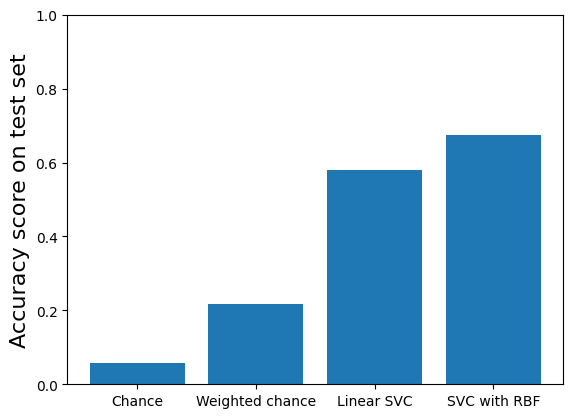

In [252]:
key, values = zip(*score.items())
plt.bar(key, values)
plt.ylabel('Accuracy score on test set', fontsize=16)
plt.ylim(0, 1)  

plt.show()

# ZSL

In [129]:
# 1min for 4 words
# 55min for 200 articles
zsl_outputs = [pipe(', '.join(kw), candidate_labels = focus_category_list) for kw in lst_keywords_test[0:2]]
y_pred_zsl = list(map(lambda x: x['labels'][0], zsl_outputs))
accuracy_score(label_test[0:2].values, y_pred_zsl)

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [148]:
y_pred_zsl

['Culture', 'Conflicts', 'Terrorism']